Dane do projektu zostały pobrane ze strony kaggle: https://www.kaggle.com/datasets/varpit94/football-teams-rankings-stats
Przedstawiają one kilka statystyk dotyczących wszystkich 98 zespołów z top 5 lig (angielskiej, hiszpańskiej, włoskiej, niemieckiej i francuskiej) w piłce nożnej z sezonu 2020-2021. Kolejne kolumny opisują kolejno: Nazwę klubu, liczbę strzelonych bramek, liczbę strzałów na mecz, liczbę otrzymanych żółtych kartek, liczbę otrzymanych czerwonych kartek, średnie posiadanie piłki, oraz średnią dokładność podań. 
Dane te chcę wykorzystać w metodach porządkowania liniowego, analizy skupień oraz skalowania wielowymiarowego i na ich podstawie stworzyć ranking drużyn najlepszych do oglądania oraz pogrupować podobne do siebie drużyny względem pewnych statystyk.

Na początek importuje wszystkie używane w projekcie biblioteki.

In [16]:
from cmath import inf
import pandas as pd
import math
from tabulate import tabulate
import statistics
from kneed import KneeLocator
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import euclidean_distances
from math import sqrt
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')


Następnie wczytuję dane oraz sprawdzam ich podstawowe statystyki. Niektóre zmienne są ze sobą dość mocno skolerowane co jest dość intuicyjne (im więcej strzałów tym większa szansa na więcej goli), jednak w żadnym przypadku korelacja nie wynosi więcej niż 0.9, więc wartości nie przekraczają przyjmowanego progu. Inaczej jest ze współczynnikiem zmienności zmiennej opisującej dokładność podań - jego wartość wynosi mniej niż 10% - z tego powodu odrzucam tę zmienną.

In [17]:
def coef_var(data):
    mean = []
    std = []
    names = []
    for column in data.loc[:, data.columns != 'Team']:
        mean.append(statistics.mean(data[column]))
        std.append(statistics.stdev(data[column]))
        names.append(column)
    coef = []
    for m, s in zip(mean, std):
        coef.append(s*100/m)
    df = pd.DataFrame([coef], columns=names, index=['Wsp.zmien'])

    return df

data = pd.read_csv("Football_teams.csv")
optimum = 58

print(data.to_string(index=False))
print(data.describe())
print(data.corr())
print(coef_var(data))
data = data.drop(('Pass%'), axis=1)

                   Team  Goals  Shots pg  yellow_cards  red_cards  Possession%  Pass%
        Manchester City     83      15.8            46          2         61.8   89.4
          Bayern Munich     99      17.1            44          3         60.1   85.5
    Paris Saint-Germain     86      15.0            73          7         61.1   89.5
              Barcelona     85      15.3            68          2         61.4   89.7
            Real Madrid     67      14.4            57          2         57.1   87.7
      Manchester United     73      13.8            64          1         54.5   84.8
               Juventus     77      15.7            76          6         56.4   88.3
            Aston Villa     55      13.7            63          4         49.1   78.6
      Borussia Dortmund     75      14.6            43          1         57.2   85.5
        Atletico Madrid     67      12.1           100          0         53.8   83.1
               Atalanta     90      16.3            66

                                                                Metoda Hellwiga
Metoda Hellwiga pozwala na stworzenie rankingu obiektów na podstawie ich cech. W tym przypadku chcę stworzyć ranking najlepszych do oglądania zespołów na podstawie kilku powyższych statystyk. Można przyjąć, że im zespół strzela więcej bramek i oddaje więcej strzałów - tym jest ciekawszy do oglądania, dlatego te zmienne są stymulantami. Liczba otrzymanych żółtych i czerwonych kartek źle świadczy o zespole - te zmienne będą destymulantami. Posiadanie piłki jest pozytywną rzeczą, ale nie chcemy, aby zespół posiadał ją cały czas i nic z tego nie robił, dlatego można przyjąć 58% posiadania za optymalną wartość - zmienna ta będzie optimum. 
Na początek zmieniam charakter wszsytkich danych na stymulanty

In [18]:

def to_stimulant(data, optimum):

    for column in data.loc[:, data.columns != 'Team']:
        for index, row in data.iterrows():
            if column == 'Possession%' and float(data.at[index, column])<optimum:
                data.at[index, column] = round(-1/(float(data.at[index, column])-optimum-1), 3)

            elif column == 'Possession%' and float(data.at[index, column])>optimum:
                data.at[index, column] = round(1/(float(data.at[index, column])-optimum+1), 3)
            elif column == 'Possession%':
                data.at[index, column] = 1
            elif column == 'yellow_cards' or column == 'red_cards':
                data.at[index, column] = -float(data.at[index, column])
            else:
                data.at[index, column] = float(data.at[index, column])
    return data

data = to_stimulant(data, optimum)
print(data.to_string(index=False, max_rows = 10))


               Team  Goals  Shots pg  yellow_cards  red_cards  Possession%
    Manchester City     83      15.8           -46         -2        0.208
      Bayern Munich     99      17.1           -44         -3        0.323
Paris Saint-Germain     86      15.0           -73         -7        0.244
          Barcelona     85      15.3           -68         -2        0.227
        Real Madrid     67      14.4           -57         -2        0.526
                ...    ...       ...           ...        ...          ...
   Sheffield United     20       8.5           -73         -3        0.062
            Crotone     45       9.5           -85         -4        0.068
          Benevento     40      11.0           -90         -5        0.068
              Dijon     25       9.2           -75         -5        0.076
         Schalke 04     25       8.9           -70         -2        0.072


Następnie standaryzuję dane, aby przykładowo liczba żółtych kartek, choć jest zdecydowanie większa od liczby czerwonych kartek, miała podobne znaczenie. Jednocześnie sprawdzam, czy nie ma wartości odstających.

In [19]:
def standardization(data):
    mean = []
    std = []
    for column in data.loc[:, data.columns != 'Team']:
        mean.append(statistics.mean(data[column]))
        std.append(statistics.stdev(data[column]))

    for column, m, s in zip(data.loc[:, data.columns != 'Team'], mean, std):
        for index, row in data.iterrows():
            data.at[index, column] = (data.at[index, column]-m)/s
    return data

data = standardization(data)
print(data.to_string(index=False, max_rows = 10))

for column in data.loc[:, data.columns != 'Team']:
    for index, row in data.iterrows():
        if abs(data.at[index, column]) >3:
            print(index, column, data.at[index, column]) # brak otrzymanego wydruku - brak wartości odstających



               Team     Goals  Shots pg  yellow_cards  red_cards  Possession%
    Manchester City  1.873824  1.836976      1.589779   0.626013     0.299958
      Bayern Munich  2.846723  2.441706      1.724495   0.154096     1.101601
Paris Saint-Germain  2.056242  1.464834     -0.228879  -1.733576     0.550907
          Barcelona  1.995436  1.604387      0.107910   0.626013     0.432403
        Real Madrid  0.900925  1.185727      0.848845   0.626013     2.516675
                ...       ...       ...           ...        ...          ...
   Sheffield United -1.956967 -1.558819     -0.228879   0.154096    -0.717780
            Crotone -0.436812 -1.093641     -1.037171  -0.317822    -0.675955
          Benevento -0.740843 -0.395875     -1.373960  -0.789740    -0.675955
              Dijon -1.652936 -1.233194     -0.363594  -0.789740    -0.620188
         Schalke 04 -1.652936 -1.372748     -0.026806   0.626013    -0.648072


Teraz ustalam wzorzec - najlepsze wartości z każdej ze statystyk.

In [20]:

def pattern(data):
    pattce = []
    for column in data.loc[:, data.columns != 'Team']:
        pattce.append(max(data[column]))
    return pattce

patt = pattern(data)
print(patt)



[2.8467229341778513, 2.4417060837616784, 1.9939256281081252, 1.569848974920173, 2.9488649662490025]


Następnie wyliczam odległości - jak daleko dana zmienna odbiega od najlepszej wartości. Metoda uwzględnia wagi - zdecydowanie większe znaczenie w ocenie zespołu pod względem satysfakcji z oglądania ma dla mnie liczba strzelanych bramek aniżeli odpowiednie posiadanie piłki.

In [21]:

def distances(data, pattern):
    scales = [0.4, 0.25, 0.1, 0.1, 0.05]
    distance = []
    for index, row in data.iterrows():
        tmp = 0
        for column, w, i in zip(data.loc[:, data.columns != 'Team'], pattern, range(len(scales))):
            tmp += scales[i]*pow(data.at[index, column]-w, 2)
            data.at[index, column] = scales[i]*pow(data.at[index, column]-w, 2)
        distance.append(round(math.sqrt(tmp), 3))
    data['Distance'] = distance
    d0 = statistics.mean(distance) + 2*statistics.stdev(distance)
    return data, d0


data, d0 = distances(data, patt)
print(data.to_string(index=False, max_rows = 10))


               Team    Goals  Shots pg  yellow_cards  red_cards  Possession%  Distance
    Manchester City 0.378613  0.091425      0.016333   0.089083     0.350835     0.962
      Bayern Munich 0.000000  0.000000      0.007259   0.200436     0.170619     0.615
Paris Saint-Germain 0.249944  0.238570      0.494086   1.091261     0.287510     1.537
          Barcelona 0.289876  0.175276      0.355706   0.089083     0.316629     1.108
        Real Madrid 1.514453  0.394371      0.131121   0.089083     0.009339     1.462
                ...      ...       ...           ...        ...          ...       ...
   Sheffield United 9.230174  4.001049      0.494086   0.200436     0.672214     3.821
            Crotone 4.312640  3.124670      0.918755   0.356330     0.656966     3.061
          Benevento 5.148251  2.012967      1.134265   0.556766     0.656966     3.084
              Dijon 8.098772  3.376224      0.555790   0.556766     0.636907     3.637
         Schalke 04 8.098772  3.637514     

Następnie przeliczam wartość miary odległości - im większa jej wartość - tym wyższe miejsce w rankingu

In [22]:

def measures(data, d0):
    data = data.drop(columns =['Goals', 'Shots pg', 'yellow_cards', 'red_cards', 'Possession%'])
    for index, row in data.iterrows():
        data.at[index, 'Distance'] = 1-(data.at[index, 'Distance']/d0)
    return data

data = measures(data, d0)
print(data.to_string(index=False, max_rows = 10))


               Team  Distance
    Manchester City  0.755044
      Bayern Munich  0.843401
Paris Saint-Germain  0.608631
          Barcelona  0.717868
        Real Madrid  0.627728
                ...       ...
   Sheffield United  0.027052
            Crotone  0.220572
          Benevento  0.214715
              Dijon  0.073904
         Schalke 04  0.086126


Ostatnim krokiem jest posorowanie wartości. Z otrzymanego rankingu wynika, że najlepszym do oglądania zespołem jest Bayern Monachium, co pokrywa się ze statystykami, w których to zespoł ten strzelał najwięcej bramek, a w końcu na statystyka ma tutaj największe znaczenie. Ogólnie rzecz biorąc, na górze rankingu znajdują się zespoły dominujące w swoich ligach, a na dole te najsłabsze w swoich ligach co pokrywa się z rzeczywistą sytuacją, w której te najlepsze zespoły mają największą oglądalność.

In [23]:

data = data.sort_values('Distance', ascending=False)
ranking_final = data.rename(columns={'Distance': 'Ranking'})
print(ranking_final.to_string(index=False))

                   Team  Ranking
          Bayern Munich 0.843401
        Manchester City 0.755044
               Atalanta 0.737475
                 Napoli 0.726271
                  Inter 0.721433
      Borussia Dortmund 0.718886
              Barcelona 0.717868
              Liverpool 0.687567
            Real Madrid 0.627728
      Manchester United 0.622381
               Juventus 0.612960
    Paris Saint-Germain 0.608631
             RB Leipzig 0.601756
               AC Milan 0.579603
              Leicester 0.577566
                   Lyon 0.571200
                Chelsea 0.554394
                  Leeds 0.542427
               Sassuolo 0.540644
    Borussia M.Gladbach 0.534278
    Eintracht Frankfurt 0.533005
                 Monaco 0.530459
                   Roma 0.528676
              Wolfsburg 0.526385
                  Lille 0.515181
              Tottenham 0.511871
               West Ham 0.481060
       Bayer Leverkusen 0.479023
          VfB Stuttgart 0.471639
          

                                                            Metoda standaryzowanych sum
Inną metodą porządkowania liniowego jest metoda standaryzowanych sum. W tej metodzie dla każdego obiektu sumuje się zestandaryzowane wcześniej wartości, a następnie konstruuje względny wskaźnik poziomu rozwoju.

Pierwsza część jest bardzo podobna, wczytuję zmienne, usuwam tę z małą zmiennością, zmieniam charakter zmiennych na stymulanty oraz standaryzuję wartości.

In [24]:
data = pd.read_csv("Football_teams.csv")
data = data.drop(('Pass%'), axis=1)
data = to_stimulant(data, optimum)
data = standardization(data)

Następnie obliczam sumy standaryzowanych rang uwzględniając takie same wagi jak poprzednio oraz sortuje je malejąco. Ich wartość mieści się w zakresie 0-1, gdzie 1 oznacza najlepszy element w rankingu, dodatkowo pozwala na zauważenie odległości między kolejnymi miejscami.

In [25]:
def sum_of_ranks(data):
    suma = []
    standard_suma = []
    scales = [0.4, 0.25, 0.1, 0.1, 0.05]
    for index, row in data.iterrows():
        tmp = 0
        counter = 0
        for i, column in enumerate((data.loc[:, data.columns != 'Team'])):
            tmp +=scales[i]*data.at[index, column]
            counter+=1
        suma.append(round(tmp/counter, 3))
    
    data['Suma'] = suma
    minn = min(suma)
    maxx = -inf
    for index, row in data.iterrows():
        tmp = 0
        if (data.at[index, 'Suma'] - minn) > maxx:
            maxx = data.at[index, 'Suma'] - minn
    for index, row in data.iterrows():
        data.at[index, 'Suma'] = (data.at[index, 'Suma'] - minn)/maxx
    return data

data = sum_of_ranks(data)
data = data.drop(['Goals', 'Shots pg', 'yellow_cards', 'red_cards', 'Possession%'], axis=1)
data = data.rename(columns={'Suma': 'Ranking'})
data = data.sort_values('Ranking', ascending=False)
print(data.to_string(index=False))


                   Team  Ranking
          Bayern Munich 1.000000
               Atalanta 0.847432
                 Napoli 0.839879
        Manchester City 0.835347
              Liverpool 0.803625
                  Inter 0.803625
      Borussia Dortmund 0.791541
              Barcelona 0.790030
             RB Leipzig 0.719033
    Paris Saint-Germain 0.706949
                   Lyon 0.705438
               Juventus 0.688822
            Real Madrid 0.679758
      Manchester United 0.670695
              Leicester 0.632931
               AC Milan 0.629909
                Chelsea 0.625378
                  Leeds 0.590634
                 Monaco 0.587613
    Eintracht Frankfurt 0.580060
               Sassuolo 0.577039
    Borussia M.Gladbach 0.572508
                   Roma 0.572508
              Wolfsburg 0.570997
       Bayer Leverkusen 0.560423
              Tottenham 0.558912
                  Lille 0.545317
               West Ham 0.525680
          VfB Stuttgart 0.510574
        At

Rankingi są do siebie podobne w ogóle, ale różnią się w szczegółach, jednak na podstawie obu można dojść do podobnych wniosków.

                                                    Grupowanie podziałowe - metoda k-średnich
Metoda k-średnich jest metodą należacą do grupy algorytmów analizy skupień tj. analizy polegającej na szukaniu i wyodrębnianiu grup obiektów podobnych (skupień) . Reprezentuje ona grupę algorytmów niehierarchicznych - należy z góry ustalić przyjmowaną liczbę skupień.
Na początku standaryzuję dane a następnie używam metody k-średnich z ustaloną z góry liczbą 3 skupień. 

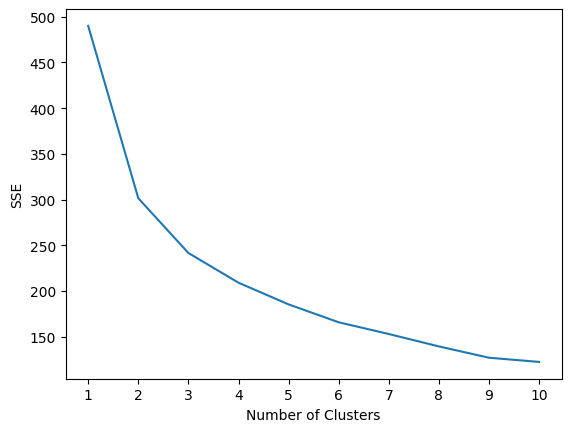

Elbow method:  3


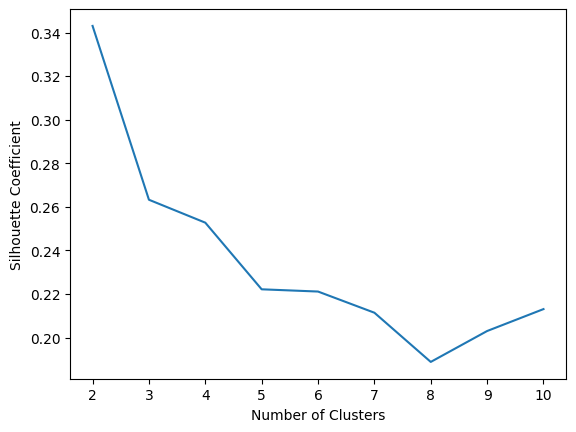

In [26]:
def kmeans(data):
    
    data2 = data[1:, 1:-1]
    scaler = StandardScaler()
    data2.astype('float')
    data2 = scaler.fit_transform(data2)

    kmeans = KMeans(
        init="random", n_clusters=3, n_init=10, max_iter=300, random_state=42
    )
    kmeans.fit(data2)

    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data2)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    print('Elbow method: ', kl.elbow)

    silhouette_coefficients = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data2)
        score = silhouette_score(data2, kmeans.labels_)
        silhouette_coefficients.append(score)

    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
data = np.genfromtxt('Football_teams.csv', delimiter=',', dtype = str)
kmeans(data)

Na podstawie otrzymanych wykresów i użytej metody łokciowej można przyjąć, że odpowiednią liczbą skupień jest liczba 3 - wykres się wypłaszcza - współczynnik podobieństwa do innych obiektów w skupienia nie zmienia się znacząco.


                                                        Grupowanie hierarchiczne
W tym przypadku nie trzeba podawać z góry liczby 'pojemników', algorytm sam dochodzi do ich liczby od góry (z 1 do n) lub od dołu (z n do 1), a bazując na odległościach między nimi, można dokonać wyboru.


Prowadząc poprzeczną linię można podzielić dane na 4 części, odległości między mniejszymi częściami są na tyle małe, że ciężko myśleć o większej liczbie 'pojemników'.

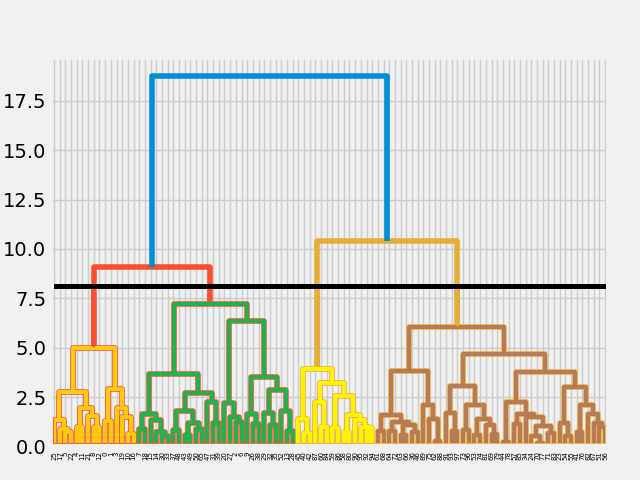

In [27]:


def hierarchical(data):
    data2 = data[1:, 1:-1]
    scaler = StandardScaler()
    data2.astype('float')
    data2 = scaler.fit_transform(data2)
    
    linkage_data = linkage(data2, method='ward', metric='euclidean')
    #dendrogram(linkage_data)
    
hierarchical(data)
Image(filename='Figure_4.png') 

                                                        Skalowanie wielowymiarowe
Aby zwizualizować podane wyniki, należy najpierw zmniejszyć rozmiar danych których niesposób zobrazować, co łatwo można uzyskać poprzez użycie gotowych funkcji. Opis każdej drużyny, w którego skład wchodzi 5 zmiennych należy przekształcić na taki, który będzie łatwo zwizualizować - w tym przypadku na wymiar 2d. Jakośc skalowania opisuje współcznnik stress, który po standaryzacji wynosi 0,015 co świadczy o tym, że dopasowanie jest dobre - mała część informacji jest zniekształcona.

In [28]:
def scaling(data):
    data2 = data[1:, 1:-1]
    scaler = StandardScaler()
    data2.astype('float64')
    data2 = scaler.fit_transform(data2)

    model2d=MDS(n_components=2, 
        metric=True, 
        n_init=4, 
        max_iter=300, 
        verbose=0, 
        eps=0.001, 
        n_jobs=None, 
        random_state=42, 
        dissimilarity='euclidean')
    
    X_trans = model2d.fit_transform(data2)

    stress = sqrt(model2d.stress_ / np.sum(data2**2))
    print("Kruskal's Stress :")
    print(stress)
    return X_trans
scaled = scaling(data)
x = []
y = []
idx = []
names = []
for i in range(2, len(scaled), 4):
    x.append(scaled[i][0])
    y.append(scaled[i][1])
    names.append(data[i][0])
    idx.append(i)
    
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# #ax.scatter(x, y)

for i, n in zip(idx, names):
    if ' ' in n: 
        ax.annotate(n.split()[0][:3].upper()+' '+n.split()[1][:3].upper(), (scaled[i][0], scaled[i][1]))
    else:
        ax.annotate(n.split()[0][:3].upper(), (scaled[i][0], scaled[i][1]))


Kruskal's Stress :
0.029787424089351894


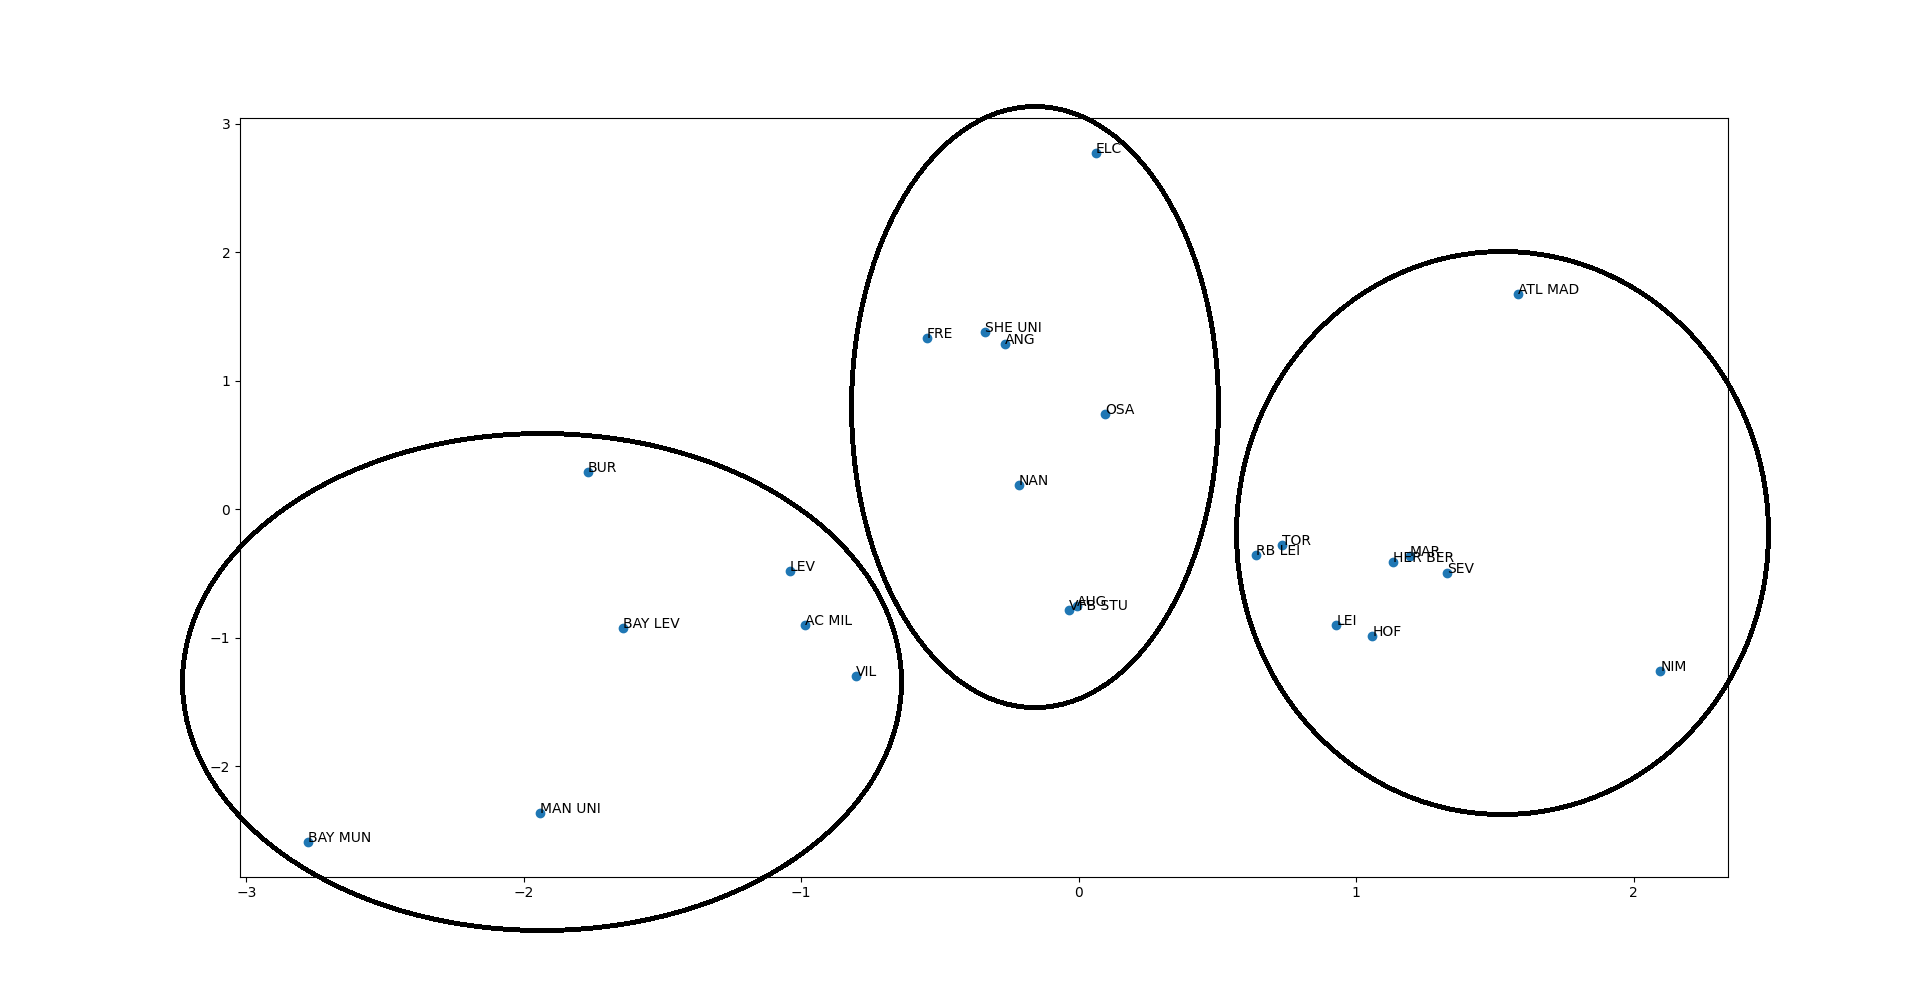

In [29]:
Image(filename='Figure_10.png', width=600) 

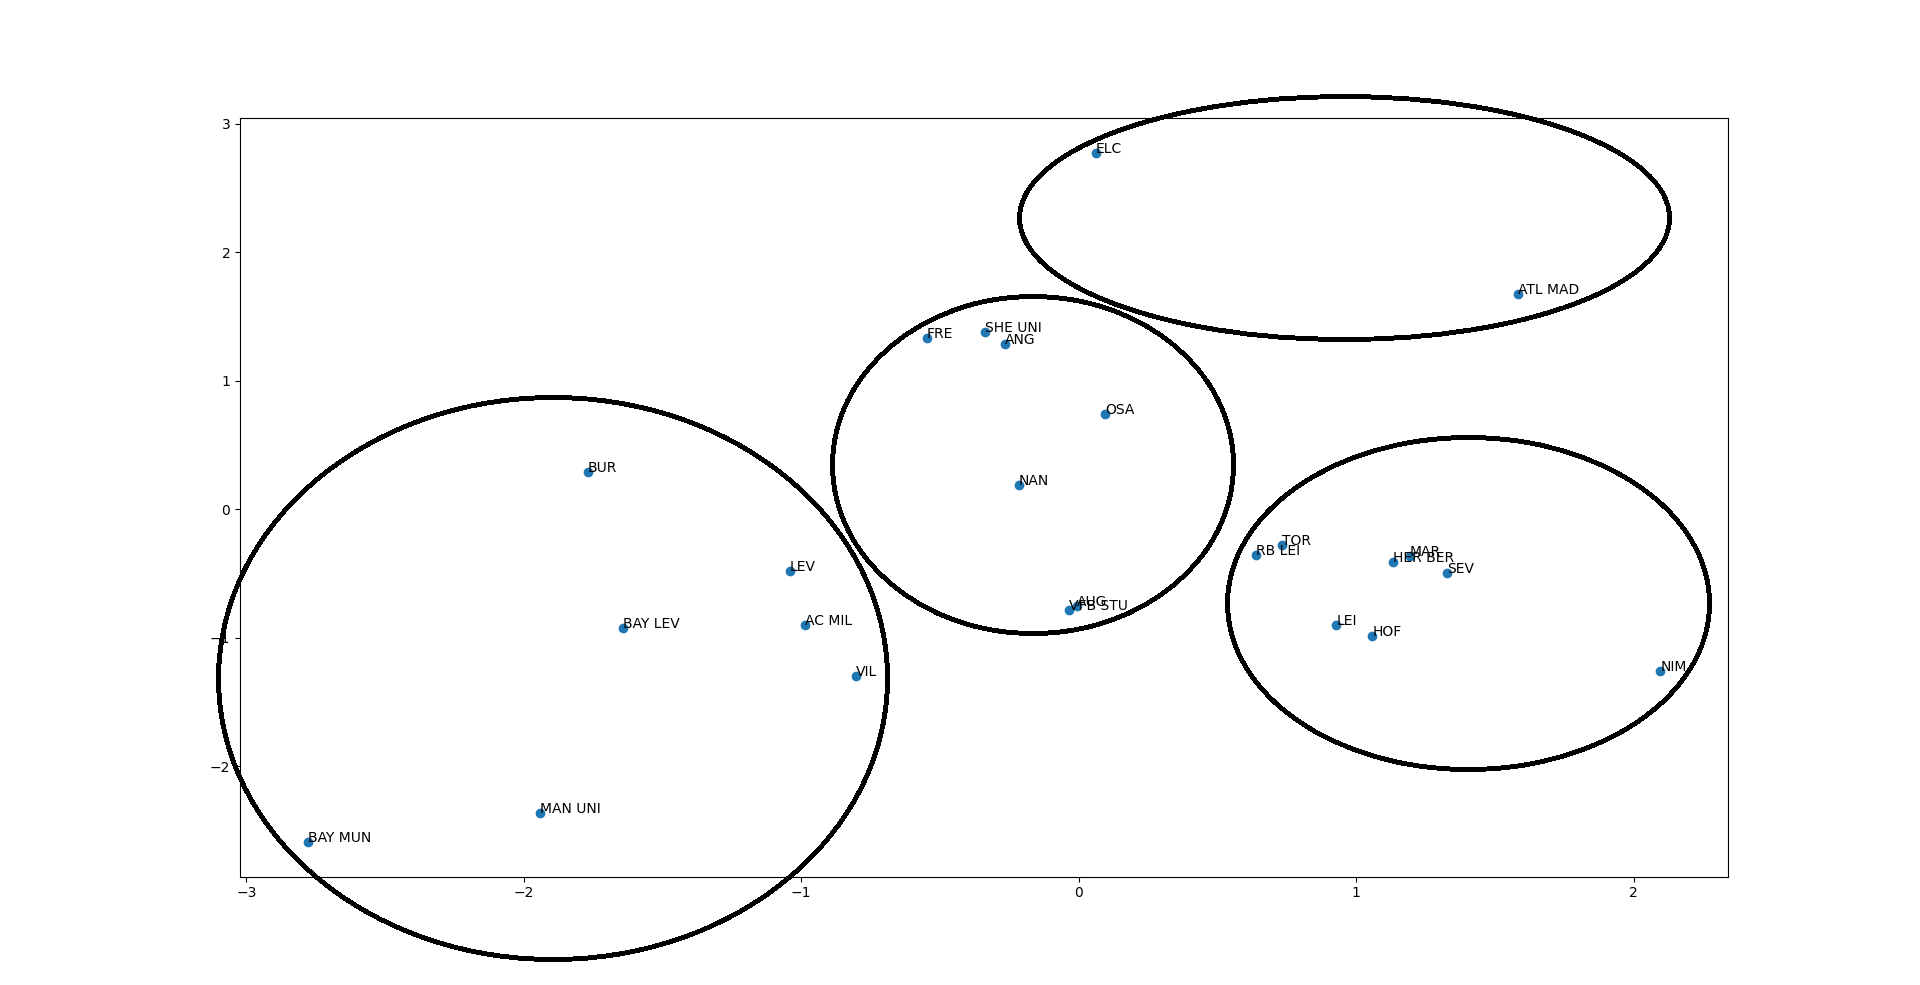

In [30]:
Image(filename='Figure_11.png', width=600) 

Na wykresie, dla lepszej czytelności, przedstawiam tylko co czwartą drużynę z rankingu. W zależności od interpretacji oraz sposobu grupowania, obiekty można zebrać w 3-4 grupy, które powinny być wewntąrz tych grupy w pewnych aspektach do siebie podobne. I tak też Angers i Sheffield United otrzymują podobną liczbę kartek, Marsylia i Sevilla mają prawie identyczną liczbę bramek oraz podobną liczbę strzałów, a Villareal i Milan mają identyczne posiadanie piłki, gdzie Manchester City znajdującę się w tej podgrupie i jednocześnie w niej odstaje, ma największe posiadanie ze wszystkich drużyn w rankingu. Wymienione przykłady mogą świadczyć o tym, że sposób w jaki obiekty zostały pogrupowane, ma rzeczywiste przełożenie w statystykach.